In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss
import xarray as xr

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt
import general_purpose.cartopy_plots as cplt

from importlib import reload

import rea.reconstruct as rec

# View the files

In [2]:
# eofs_re = np.load('EOFs_new.npy')
eofs_re = np.load('../veros-noise-product/ocean/EOFs_new.npy')
eofs_re.shape

(136, 40, 90)

In [3]:
pcs_re = np.load('PCs_new.npy')
pcs_re.shape

(1711, 136)

In [4]:
lm = np.load('landMask.npy')
lm.shape

(40, 90)

In [11]:
lags = np.load('Lags.npy')
lags.shape

(136,)

In [6]:
yw_rho = np.load('yw_rho_new.npy')
yw_sigma = np.load('yw_sigma_new.npy')

yw_rho.shape, yw_sigma.shape

((136, 196), (136,))

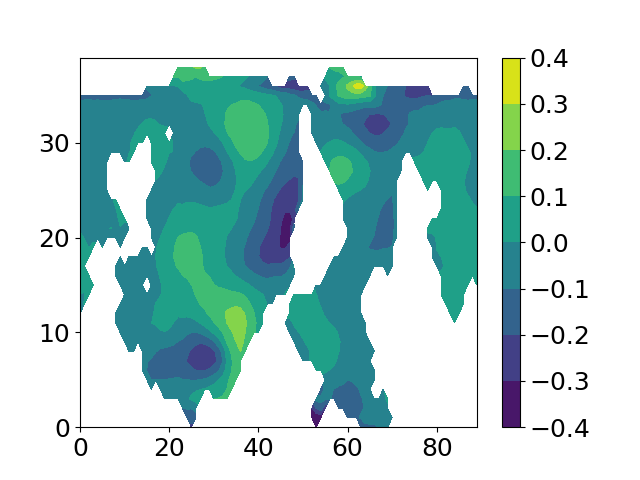

In [3]:
plt.figure()
plt.contourf(eofs_re[7])
plt.colorbar()

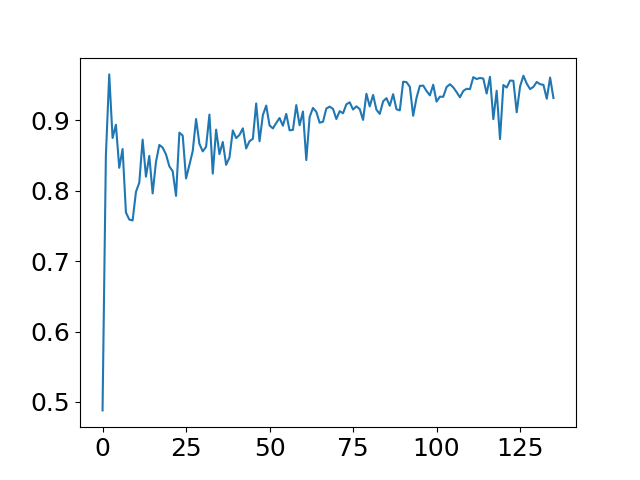

In [8]:
plt.figure()
plt.plot(yw_sigma)

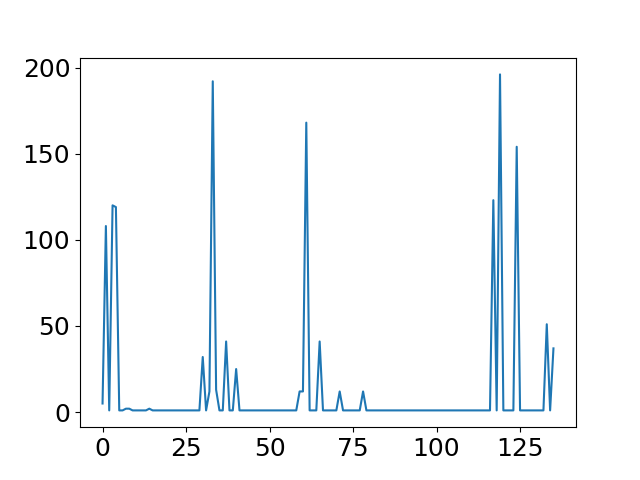

In [13]:
plt.figure()
plt.plot(lags)

In [9]:
yw_rho.shape

(136, 196)

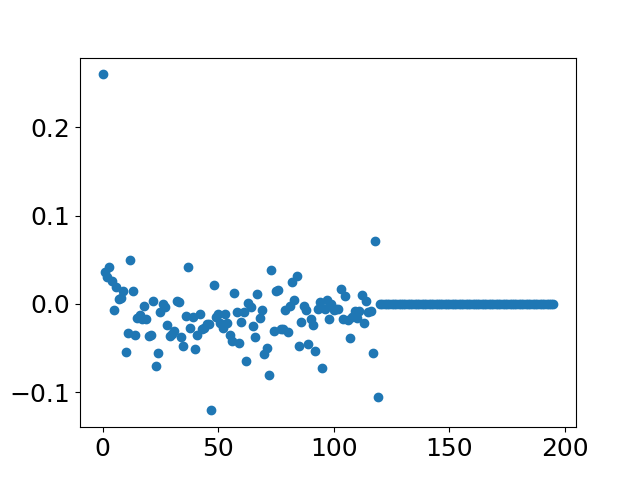

In [17]:
eof_id = 4

plt.close(4)
plt.figure(num=4)
_ = plt.scatter(np.arange(yw_rho.shape[1]), yw_rho[eof_id - 1])

### Plot the EOFs with the proper coordinates

In [18]:
av = xr.load_dataset('../veros-temp-noise-old/__test__/e1.0000.averages.nc')

In [19]:
av

<xarray.Dataset>
Dimensions:            (Time: 1, zt: 40, yu: 40, xt: 90, yt: 40, xu: 90,
                        zw: 40, isle: 5)
Coordinates:
  * Time               (Time) float64 2.556e+07
  * isle               (isle) float64 1.0 2.0 3.0 4.0 5.0
  * xt                 (xt) float64 88.0 92.0 96.0 100.0 ... 436.0 440.0 444.0
  * xu                 (xu) float64 90.0 94.0 98.0 102.0 ... 438.0 442.0 446.0
  * yt                 (yt) float64 -82.38 -77.62 -72.89 ... 63.38 68.11 72.87
  * yu                 (yu) float64 -80.0 -75.26 -70.54 ... 65.75 70.49 75.24
  * zt                 (zt) float64 -5.261e+03 -4.984e+03 ... -32.93 -10.07
  * zw                 (zw) float64 -5.123e+03 -4.847e+03 ... -21.5 0.0
Data variables: (12/26)
    B1_gm              (Time, zt, yu, xt) float64 nan nan nan ... nan nan nan
    B2_gm              (Time, zt, yt, xu) float64 nan nan nan ... nan nan nan
    Hd                 (Time, zt, yt, xt) float64 nan nan nan ... nan nan nan
    K_gm               (Time, zw, yt, xt) float64 nan nan nan ... nan nan nan
    L_rhines           (Time, zw, yt, xt) float64 nan nan nan ... nan nan nan
    L_rossby           (Time, yt, xt) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    tke                (Time, zw, yt, xt) float64 nan nan nan ... nan nan nan
    tke_diss           (Time, zw, yt, xt) float64 nan nan nan ... nan nan nan
    tke_surf_corr      (Time, yt, xt) float64 nan nan nan nan ... nan nan nan
    u                  (Time, zt, yt, xu) float64 nan nan nan ... nan nan nan
    v                  (Time, zt, yu, xt) float64 nan nan nan ... nan nan nan
    w                  (Time, zw, yt, xt) float64 nan nan nan ... nan nan nan

In [29]:
av['yt']

<xarray.DataArray 'yt' (yt: 40)>
array([-82.378007, -77.621993, -72.894009, -68.193725, -63.54852 , -58.957109,
       -54.445632, -50.011315, -45.67859 , -41.442792, -37.326328, -33.322406,
       -29.45125 , -25.703867, -22.098298, -18.62342 , -15.295222, -12.100637,
        -9.053834,  -6.140064,  -3.371963,  -0.458193,   2.58861 ,   5.783195,
         9.111392,  12.58627 ,  16.19184 ,  19.939223,  23.810379,  27.814301,
        31.930765,  36.166562,  40.499288,  44.933605,  49.445082,  54.036493,
        58.681698,  63.381982,  68.109966,  72.86598 ])
Coordinates:
  * yt       (yt) float64 -82.38 -77.62 -72.89 -68.19 ... 63.38 68.11 72.87
Attributes:
    long_name:  Meridional coordinate (T)
    units:      degrees_north

In [32]:
LON, LAT = np.meshgrid(av['xt'] - 360, av['yt'])

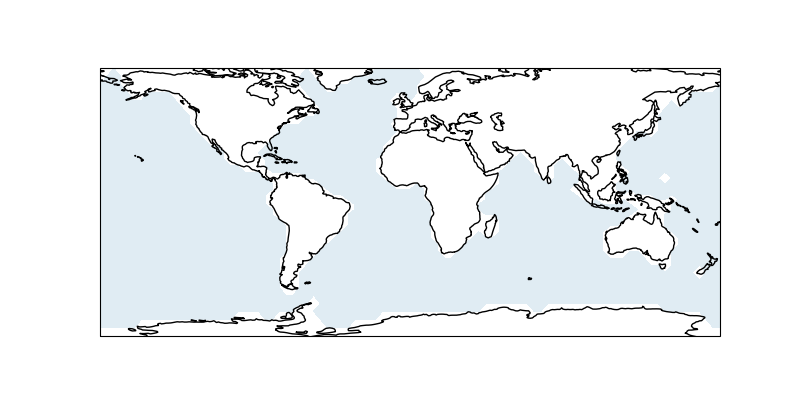

In [62]:
plt.close(2)
fig = plt.figure(num=2, figsize=(8,4))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, LON, LAT,
                 # eofs_re[0][::-1,:],
                 lm[::-1],
                 greenwich=True,
                 draw_gridlines=False, draw_labels=False,
                 put_colorbar=False
                )

In [50]:
reload(cplt)

<module 'general_purpose.cartopy_plots' from '/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/veros-temp-noise/../general_purpose/cartopy_plots.py'>

In [83]:
136 - 48

88

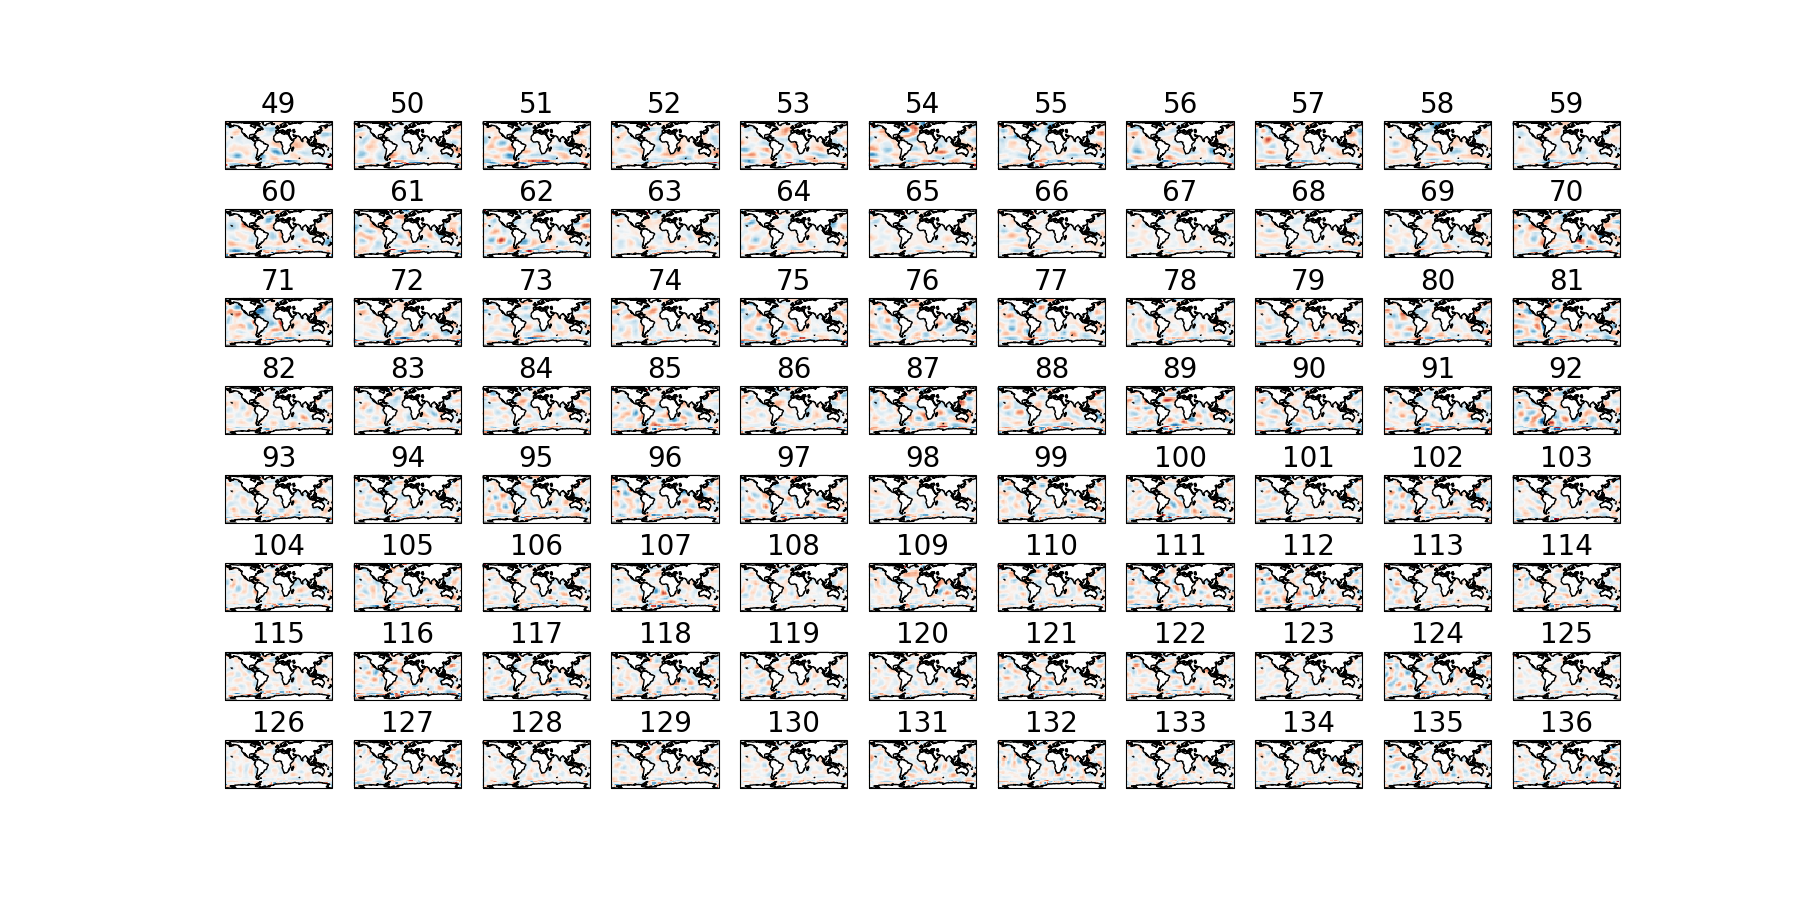

In [93]:
vmax = np.nanmax(np.abs(eofs_re))
ofl = (8,11)
plots_per_fig = np.prod(ofl)
start = 48
plt.close('all')
i = 0
while i < 1:
    lower = start + plots_per_fig*i
    upper = min(start + plots_per_fig*(i+1), eofs_re.shape[0])
    if upper < lower:
        break
    ims = cplt.mfp(LON, LAT, eofs_re[lower:upper].transpose(1,2,0)[::-1,:,:],
                   projections=cplt.ccrs.PlateCarree(), extents=None, titles=list(range(lower + 1,upper + 1)),
                   figsize=(18,9),
                   # figsize=(12,6),
                   fig_num = 8 + i,
                   one_fig_layout=ofl,
                   # mx=vmax,
                   # colorbar='shared',
                   colorbar='individual',
                   put_colorbar=False,
                   # apply_tight_layout=False
                  )
    i += 1

# Effect of noise on the dynamics

In [2]:
def get_run(folder, iteration=None):
    if iteration is None:
        run = {'folder': folder, 'rec_dict': ut.json2dict(f'{folder}/reconstructed.json')}
    else:
        run = {'folder': folder, 'rec_dict': rec.reconstruct(f'{folder}/i{iteration:04d}')}
    
    run['abs_observables'] = {}
    run['rel_observables'] = {}
    for rname, r in run['rec_dict']['members'].items():
        last_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][-1]}/{r['ancestry'][-1]}-traj.npy")
        first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
        run['abs_observables'][rname] = last_segment_traj[-1,1]
        run['rel_observables'][rname] = last_segment_traj[-1,1] - first_segment_traj[0,1]
        
    first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
    run['duration'] = last_segment_traj[-1,0] - first_segment_traj[0,0]
        
    return run

def compute_trajectories(run):
    folder = run['folder']
    rec_dict = run['rec_dict']
    rec_trajs = {}

    for rname, r in tqdm(rec_dict['members'].items()):
        traj = []
        for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
            traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
        traj = np.concatenate(traj)

        rec_trajs[rname] = traj
    
    run['traj'] = rec_trajs
    
    return rec_trajs

def plot_traj(run, start=0, **kwargs):
    if 'traj' not in run:
        compute_trajectories(run)
    for traj in run['traj'].values():
        plt.plot(traj[start:,0]-traj[0,0], -traj[start:,1], **kwargs)

def expectation(run, func, mode='abs', **kwargs):
    _f = np.array([func(x, **kwargs) for x in run[f'{mode}_observables'].values()])
    _w = np.array([r['weight'] for r in run['rec_dict']['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean((_f*_w)**2)/len(_w))

    return unc.ufloat(mean,std)

def f(x, a):
    return float(x>a)

def get_infos(folder):
    i = 0
    infos = {}
    while True:
        try:
            infos[i] = ut.json2dict(f'{folder}/i{i:04d}/info.json')
            i += 1
        except FileNotFoundError:
            break
            
    return infos


In [3]:
run_no_noise = get_run('../veros/__test__/r-0_minimal')
run_noise = get_run('__test__/rn-0_minimal')

compute_trajectories(run_no_noise)
_ = compute_trajectories(run_noise)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Plot the two trajectories

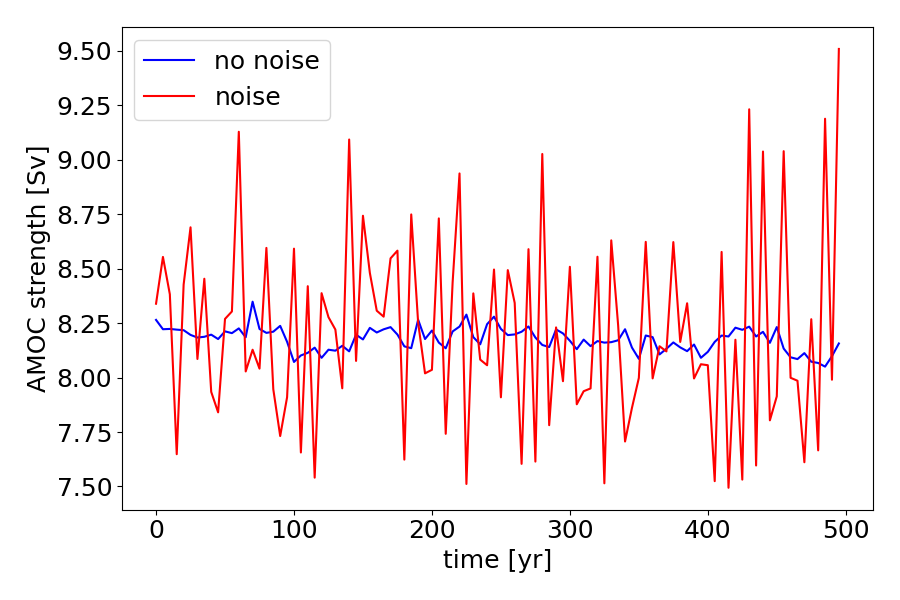

In [4]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

plot_traj(run_no_noise, color='blue', label='no noise')
plot_traj(run_noise, color='red', label='noise')

plt.legend()

plt.xlabel('time [yr]')
plt.ylabel('AMOC strength [Sv]')

fig.tight_layout()

In [13]:
np.std(run_no_noise['traj']['r1'][...,1])

0.05338654080420439